In [57]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import requests
from StringIO import StringIO
import urllib

import unittest

import sys
import os

import time

caffe_root = '/home/jonnatas/workspace_python/caffe/'
sys.path.insert(0, caffe_root + 'python')
xml_detector_faces = "/usr/local/share/OpenCV/haarcascades/haarcascade_frontalface_alt.xml"

print caffe_root
import caffe


/home/jonnatas/workspace_python/caffe/


In [58]:
caffe.set_mode_cpu()

model_def = os.path.join(caffe_root, 'models', 'bvlc_reference_caffenet','deploy.prototxt')
model_weights = os.path.join(caffe_root, 'models','bvlc_reference_caffenet','bvlc_reference_caffenet.caffemodel')

net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)

mu = np.load(os.path.join(caffe_root, 'python','caffe','imagenet','ilsvrc_2012_mean.npy'))
mu = mu.mean(1).mean(1)  # average over pixels to obtain the mean (BGR) pixel values
print 'mean-subtracted values:', zip('BGR', mu)

# create transformer for the input called 'data'
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})

transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel
transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR

net.blobs['data'].reshape(50,        # batch size
                          3,         # 3-channel (BGR) images
                          227, 227)  # image size is 227x227



mean-subtracted values: [('B', 104.0069879317889), ('G', 116.66876761696767), ('R', 122.6789143406786)]


In [59]:
def printFaces(faces,coordinates):
    print('Total of faces detected = '+str(len(faces)))
    print 'coordinates: '
    
    for coordinate in coordinates:
        x,y,w,h = coordinate
        print [(x,y), (x+w,y+h), (x+w, y), (x, y+h)]
        print '\n'
    print '\n'

In [60]:
def contFaces(faces,frame,DOWNSCALE):
    coordinates = []
    # print 'face detected!'
    for i in faces:
        x, y, w, h = [ v*DOWNSCALE for v in i ]

        coordinates.append((x,y,w,h))
        # print x,y,w,h
        cv2.rectangle(frame, (x,y), (x+w,y+h), (0,255,0))
    
    return coordinates
    

In [61]:
def detect(frame):
    height, width, depth = frame.shape
   
    # create grayscale version
    grayscale = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # equalize histogram
    cv2.equalizeHist(grayscale, grayscale)
    
    # detect objects
    classifier = cv2.CascadeClassifier(xml_detector_faces)
    
    DOWNSCALE = 4
    minisize = (frame.shape[1]/DOWNSCALE,frame.shape[0]/DOWNSCALE)
    miniframe = cv2.resize(frame, minisize)
    faces = classifier.detectMultiScale(miniframe)
    coordinates = []
    
    if len(faces)>0:
        coordinates = contFaces(faces,frame,DOWNSCALE)
        print 'face detected!'
    printFaces(faces, coordinates)
    
    return frame, len(faces)

In [62]:
def get_image_url(url):
        cap = cv2.VideoCapture(url)
        ret,img = cap.read()

        return img

In [63]:
def cats_and_dogs_probability(output_prob, labels, path_animal):
        labels_animal = np.loadtxt(path_animal, str, delimiter='\t')
        
        index = 0
        list_animal = []
        probability_animal = 0.0
        
        for i in labels:
                if i in labels_animal:
                        list_animal.append((output_prob[index],labels[index]))
                        probability_animal += output_prob[index]
                index += 1
        list_animal = sorted(list_animal, reverse=True)
        
        for i in list_animal:
            probability , animal_class = i
        
        return probability_animal

In [64]:
def probability(image):    
        transformed_image = transformer.preprocess('data', image)
        plt.imshow(image)
        plt.axis('off')

        # copy the image data into the memory allocated for the net
        net.blobs['data'].data[...] = transformed_image

        ### perform classification
        output = net.forward()

        output_prob = output['prob'][0]  # the output probability vector for the first image in the batch

        # print 'predicted class is:', output_prob.argmax()
        
        # load ImageNet labels
        labels_file = caffe_root + 'data/ilsvrc12/synset_words.txt'
   
        labels = np.loadtxt(labels_file, str, delimiter='\t')

        dogs_file = os.path.join(caffe_root, 'data','ilsvrc12','dogs.txt')
        cats_file = os.path.join(caffe_root, 'data', 'ilsvrc12','cats.txt')

        top_inds = output_prob.argsort()[::-1][:]

        probability_dogs = cats_and_dogs_probability(output_prob, labels, dogs_file)
        probability_cats = cats_and_dogs_probability(output_prob, labels, cats_file)
               
        print '\n\n::Results::\n'
        print 'Feline probability: ' + str( (probability_cats) * 100.0 ) + "%"
        print 'Canine probability: ' + str( (probability_dogs) * 100.0 ) + "%"
        print 'Most probable synset:', labels[output_prob.argmax()]
        print 'Compatibility: ' + str(output_prob[output_prob.argmax()] * 100.0) + "%"
        print '\n'
        
        return probability_dogs * 100.0 , probability_cats * 100.0 


In [65]:
def options():
        print('1 - image')
        print('2 - url')
        print('3 - camera')
        print('4 - exit')

        return int(raw_input(''))

In [66]:
def option_image(image_name):
        image = cv2.VideoCapture(image_name)
        ret, img = image.read()
        image_recognition = caffe.io.load_image(image_name)
        pb = probability(image_recognition)
        image_detected, faces = detect(img)
        
        plt.imshow(image_detected[:,:,::-1])
        plt.title('Detection result')
        plt.axis('off')
        plt.show()
        
        return faces, pb

In [72]:
def option_url(image_url):
        image = get_image_url(image_url)
        
        urllib.urlretrieve(image_url, os.path.join(caffe_root, 'examples', 'images','url.jpg'))
        image_recognition = caffe.io.load_image(os.path.join(caffe_root, 'examples', 'images','url.jpg'))

        pb = probability(image_recognition)
        image_detected, faces = detect(image)
        plt.imshow(image_detected[:,:,::-1])
        plt.title('Detection result')
        plt.axis('off')
        plt.show()
        return faces, pb

In [68]:

def get_image_camera():
        #cap = cv2.VideoCapture(0)
        cap = cv2.VideoCapture(0)
        while(True):
            # Capture frame-by-frame
            ret, frame = cap.read()
            img = frame.copy()
            # Call the function
            frame, faces = detect(frame)

            # Display the resulting frame
            cv2.imshow('frame',frame)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

        cv2.imwrite("frame.jpg", frame)
        cv2.imwrite(os.path.join(caffe_root, 'examples', 'images','frame.jpg'), frame)
      
        # When everything done, release the capture
        cap.release()
        cv2.destroyAllWindows()
        cap = cv2

        return frame

In [69]:
def option_camera():
        frame = get_image_camera()
        image_recognition = caffe.io.load_image(os.path.join(caffe_root, 'examples', 'images','frame.jpg'))
        pb = probability(image_recognition)
        image_detected, faces = detect(frame)
        
        plt.imshow(image_detected[:,:,::-1])
        plt.title('Detection result')
        plt.axis('off')
        plt.show()
        return faces, pb

1 - image
2 - url
3 - camera
4 - exit
1
File name:
cachorro.jpg


::Results::

Feline probability: 0.000219859739659%
Canine probability: 99.9624692421%
Most probable synset: n02106550 Rottweiler
Compatibility: 98.9165604115%


Total of faces detected = 0
coordinates: 




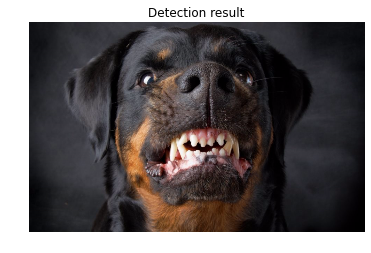

NameError: global name 'result' is not defined

In [71]:
if __name__ == '__main__':
    while True:
        option = options()
        t_init = time.time()
        
        if option == 1:
            image_name = raw_input('File name:\n')
            option_image(image_name)
            
        elif option == 2:
            image_url = raw_input('enter the image url:\n')
            option_url(image_url)
            
        elif option == 3:
            option_camera()
            
        elif option == 4:
            break
        t_end = time.time()
        
        print ("Time: "+str(t_end-t_init)+" (s)")
 
    print ("Time of oprion Image: "+str(t_end-t_init)+" (s)")

# Unit Tests

## Teste de desempenho na execução dos metodos.

In [35]:
class TestFileImage(unittest.TestCase):
    def test_option_image(self):
        total_faces, pb = option_image('two_faces.jpg')
        self.assertEqual(total_faces, 2)
    
    def test_option_image_dogs(self):
        total_faces, pb = option_image('cachorro.jpg')
        self.assertGreaterEqual(pb[0], 0.98)
        
    def test_option_image_cats(self):
        total_faces, pb = option_image('cat-300572_960_720.jpg')
        self.assertGreaterEqual(pb[1], 0.98)

test_option_image (__main__.TestFileImage) ... 



::Results::

Feline probability: 0.140127041641%
Canine probability: 81.9848412054%
Most probable synset: n02088364 beagle
Compatibility: 28.1335562468%


56 36 124 124
340 40 136 136
Total of faces detected = 2
coordinates: 
[(56, 36), (180, 160), (180, 36), (56, 160)]


[(340, 40), (476, 176), (476, 40), (340, 176)]






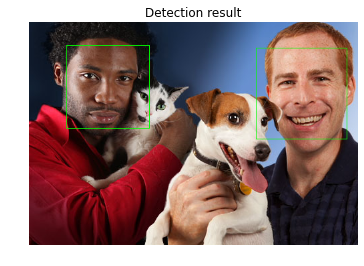

ok
test_option_image_cats (__main__.TestFileImage) ... 



::Results::

Feline probability: 99.9988407934%
Canine probability: 0.000108034221693%
Most probable synset: n02123159 tiger cat
Compatibility: 85.202896595%


Total of faces detected = 0
coordinates: 




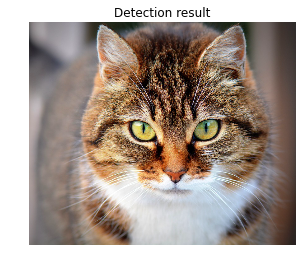

ok
test_option_image_dogs (__main__.TestFileImage) ... 



::Results::

Feline probability: 0.000219859739659%
Canine probability: 99.9624692421%
Most probable synset: n02106550 Rottweiler
Compatibility: 98.9165604115%


Total of faces detected = 0
coordinates: 




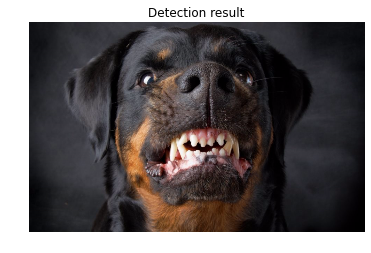

ok

----------------------------------------------------------------------
Ran 3 tests in 18.857s

OK


<unittest.runner.TextTestResult run=3 errors=0 failures=0>

In [36]:
suite = unittest.TestLoader().loadTestsFromTestCase(TestFileImage)
unittest.TextTestRunner(verbosity=2,stream=sys.stderr).run(suite)

## Testes das unitarios para a camera

test_option_camera_faces (__main__.TestCamera_Url) ... 

Total of faces detected = 0
coordinates: 


Total of faces detected = 0
coordinates: 


Total of faces detected = 0
coordinates: 


Total of faces detected = 0
coordinates: 


Total of faces detected = 0
coordinates: 


Total of faces detected = 0
coordinates: 


Total of faces detected = 0
coordinates: 


Total of faces detected = 0
coordinates: 


Total of faces detected = 0
coordinates: 


Total of faces detected = 0
coordinates: 


Total of faces detected = 0
coordinates: 


Total of faces detected = 0
coordinates: 


Total of faces detected = 0
coordinates: 


Total of faces detected = 0
coordinates: 


Total of faces detected = 0
coordinates: 


Total of faces detected = 0
coordinates: 


Total of faces detected = 0
coordinates: 


Total of faces detected = 0
coordinates: 


Total of faces detected = 0
coordinates: 


Total of faces detected = 0
coordinates: 


Total of faces detected = 0
coordinates: 


Total of faces detected = 0
coordinates: 


Total of faces detected = 0
coor

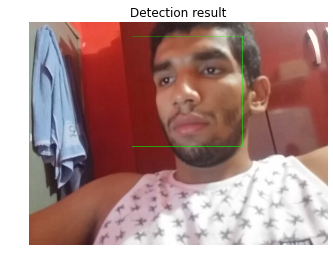

ok
test_option_image_dogs (__main__.TestCamera_Url) ... 



::Results::

Feline probability: 0.140127041641%
Canine probability: 81.9848412054%
Most probable synset: n02088364 beagle
Compatibility: 28.1335562468%


face detected!
Total of faces detected = 2
coordinates: 
[(56, 36), (180, 160), (180, 36), (56, 160)]


[(340, 40), (476, 176), (476, 40), (340, 176)]






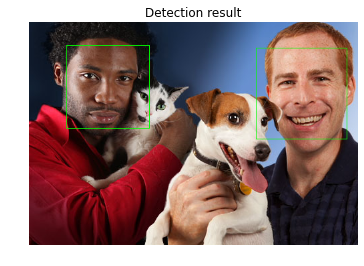

ok

----------------------------------------------------------------------
Ran 2 tests in 30.527s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

In [56]:
class TestCamera_Url(unittest.TestCase):       
    def test_option_camera_faces(self):
        total_faces, pb = option_camera()
        self.assertEqual(total_faces, 1)
        
    def test_option_image_dogs(self):
        total_faces, pb = option_url("http://img.webmd.com/dtmcms/live/webmd/consumer_assets/site_images/articles/health_tools/cat_people_vs_dog_people_slideshow/webmd_rf_photo_of_cat_and_dog_people.jpg")
        self.assertGreaterEqual(pb[0], 0.98) and self.assertGreaterEqual(pb[1], 0.98)    

suite2 = unittest.TestLoader().loadTestsFromTestCase(TestCamera_Url)
unittest.TextTestRunner(verbosity=2,stream=sys.stderr).run(suite2)

In [25]:
def test_file_path(self):
    t_init = time.time()
    option_image('image.jpg')   
    t_end = time.time() 
    t_image = t_end - t_init
    print "Time ="+str(t_image)
    self.assertLessEqual(t_image, 20.00)